Image classification with CNNs
================

The goal of this exercise is to implement a specific CNN architecture with PyTorch and train it on the CIFAR-10 image classification dataset. We will start by introducing the dataset and then implement a `nn.Module` and a useful `Solver` class. Seperating the model from the actual training has proven itself as a sensible design decision. By the end of this exercise you should have succesfully trained your (possible) first CNN model and have a boilerplate `Solver` class which you can reuse for the next exercise and your future research projects.

For an inspiration on how to implement a model or the solver class you can have a look at [these](https://github.com/pytorch/examples) PyTorch examples.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from data_utils import get_Cancer_datasets
from data_utils import data_augmentation

csv_full_name = '/Users/yuminsun/dl4cvproject/data/train.csv'
img_folder_full_name = '/Users/yuminsun/dl4cvproject/data/train256'

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cancer Dataset
=========

Since the focus of this exercise should be neural network models and how to successfully train them, we provide you with preprocessed and prepared datasets. For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the `Dataset` classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the `Dataset` classes. See `torchvision.Transform` for examples.</p>
</div>

In [21]:
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.

data,fractions = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name)

# print("Train size: %i" % len(train_data))
# print("Val size: %i" % len(val_data))
# print("Test size: %i" % len(test_data))

  1%|          | 172/18577 [00:00<00:43, 421.49it/s]

bad image:  /Users/yuminsun/dl4cvproject/data/train256/scan_00010127.png total bad images:  1


  4%|▎         | 670/18577 [00:01<00:44, 402.99it/s]

bad image:  /Users/yuminsun/dl4cvproject/data/train256/scan_00010909.png total bad images:  2


  5%|▌         | 975/18577 [00:02<00:45, 386.56it/s]


Total good data size:  1000
Scale to [0,1]...
(1000, 1, 256, 256) <class 'numpy.ndarray'>


  0%|          | 0/18577 [00:00<?, ?it/s]

Done Scale to [0,1]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.021
0.037
0.304
0.078
0.124
0.065
0.142
0.019
0.003
0.017
0.047
0.097
0.026
0.02
label shape (1000,)
OK...


In [22]:
fractions


[0.021,
 0.037,
 0.304,
 0.078,
 0.124,
 0.065,
 0.142,
 0.019,
 0.003,
 0.017,
 0.047,
 0.097,
 0.026,
 0.02]

In [23]:
aug_data = data_augmentation(data,fractions)

augment image i =  5
augment image i =  14
augment image i =  18
augment image i =  19
augment image i =  21


KeyboardInterrupt: 

In [19]:
print(len(aug_data))

1010


Visualize Examples
------------------

To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.


( 0 ,.,.) = 
 -0.0609 -0.0415 -0.0415  ...  -0.9119 -0.9313 -0.9313
 -0.0609 -0.0415 -0.0609  ...  -0.8732 -0.8926 -0.8926
 -0.1189 -0.0996 -0.0609  ...  -0.8346 -0.8539 -0.8346
           ...             ⋱             ...          
  1.3704  1.3511  1.3898  ...   1.0803  1.0610  1.0029
  1.3511  1.3704  1.3898  ...   1.0610  1.0416  1.0223
  1.3704  1.3898  1.4091  ...   1.0610  1.0416  1.0416

( 1 ,.,.) = 
 -0.0609 -0.0415 -0.0415  ...  -0.9119 -0.9313 -0.9313
 -0.0609 -0.0415 -0.0609  ...  -0.8732 -0.8926 -0.8926
 -0.1189 -0.0996 -0.0609  ...  -0.8346 -0.8539 -0.8346
           ...             ⋱             ...          
  1.3704  1.3511  1.3898  ...   1.0803  1.0610  1.0029
  1.3511  1.3704  1.3898  ...   1.0610  1.0416  1.0223
  1.3704  1.3898  1.4091  ...   1.0610  1.0416  1.0416

( 2 ,.,.) = 
 -0.0609 -0.0415 -0.0415  ...  -0.9119 -0.9313 -0.9313
 -0.0609 -0.0415 -0.0609  ...  -0.8732 -0.8926 -0.8926
 -0.1189 -0.0996 -0.0609  ...  -0.8346 -0.8539 -0.8346
           ...         

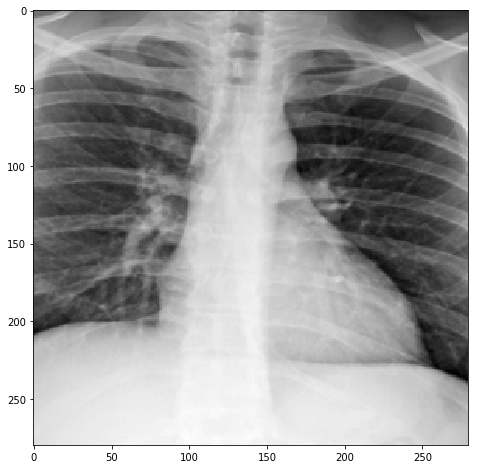

In [6]:

index = 1899
img, _ = train_data[index]
print(img)
#print(img)
to_plot = img.cpu().numpy() #+ mean_image
print(to_plot.shape)
plt.imshow(to_plot[0])
plt.show()

## Model Architecture and Forward Pass 

After you understood the core concepts of PyTorch and have a rough idea on how to implement your own model, complete the initialization and forward methods of the `ClassificationCNN` in the `dl4cv/classifiers/classification_cnn.py` file. Note that we do not have to implement a backward pass since this is automatically handled by the `autograd` package.

Use the cell below to check your results:

## Training and Validation with the Solver
We train and validate our previously generated model with a seperate `Solver` class defined in `dl4cv/solver.py`. Complete the `.train()` method and try to come up with an efficient iteration scheme as well as an informative training logger.

Use the cells below to test your solver. A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>As seen below, the design of our `Solver` class is indepdenent of the particular model or data pipeline. This facilitates the reuse of the class and its modular structure allows the training of different models.</p>
</div>

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

## Train the Network
Now train your model with the full dataset. By training a `ThreeLayerCNN` model for one epoch, you should already achieve greater than 40% accuracy on the validation set. If your training is painfully slow check if you did not forget to call the `nn.Module.cuda()` method.

For the overfitting example we provided you with a set of hyperparamters (`hidden_dim`, `lr`, `weight_decay`, ...). You can start with the same parameter values but in order to maximize your accuracy you should try to train multiple models with different sets of hyperparamters. This process is called hyperparameter optimization.

In [23]:
from yz.classifiers.classification_cnn import ClassificationCNN
from yz.classifiers.transferred_alexnet import alexnet
from yz.solver import Solver
from yz.data_utils import get_balanced_weights
from torchvision import models
import torch.nn as nn

weights = get_balanced_weights(train_label_list, 14)
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=40, shuffle=False, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=40, shuffle=False, num_workers=8)

model = alexnet(pretrained=True)
#model.classifier  = nn.Sequential(
#            nn.Linear(12544, 4096),
#            nn.ReLU(inplace=True),
#            nn.Linear(4096, 14),
#)
#model.classifier = nn.Sequential(
#            nn.Linear(12544, 4096),
#            nn.ReLU(inplace=True),
#            nn.Linear(4096, 4096),
#            nn.ReLU(inplace=True),
#            nn.Linear(4096, 14)
#)

#list(model.classifier.children())[:-1] = nn.Linear(4096, 14)  
#for param in model.features.parameters():
#    param.requires_grad = False
solver = Solver()
solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

START TRAIN.



0it [00:00, ?it/s]



RuntimeError: size mismatch, m1: [40 x 12544], m2: [9216 x 4096] at /opt/conda/conda-bld/pytorch-cpu_1515613813020/work/torch/lib/TH/generic/THTensorMath.c:1416

# Test your Model
Run your best model on the test set. You should easily achieve a score above 10% (random guessing for a classification task with 10 classes) accuracy on the given test set:

In [22]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False, num_workers=4)

scores = []
for inputs, target in tqdm(test_loader):
    #print(type(target))
    inputs, targets = Variable(inputs), Variable(target)
    #if model.is_cuda:
    #    inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    scores.extend((preds == targets).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

100%|██████████| 27/27 [01:05<00:00,  2.43s/it]

Test set accuracy: 0.314243


## Get final test data

In [14]:
from yz.data_utils import get_Cancer_datasets
csv_full_name = '/home/hpc/pr92no/ga42cih2/Projects/dl4cvproject/data/test.csv'
img_folder_full_name = '/home/hpc/pr92no/ga42cih2/Projects/dl4cvproject/data/test_400'
test_X, csv_test = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name, mode='upload')

100%|██████████| 12386/12386 [01:21<00:00, 152.05it/s]


transforming...
X.shape:(12386, 3, 280, 280)
X_original.shape:(12386, 280, 280)
mean:134.3479535516976
std:51.72722775048222
Done transforming...


In [15]:
v = csv_test['detected'].values

KeyError: 'detected'

In [ ]:
print(type(csv_test))
print(test_X.size())

In [16]:
try:
    del csv_test['age']
except KeyError as e:
    print(e)
try:
    del csv_test['gender']
except KeyError as e:
    print(e)
try:
    del csv_test['view_position']
except KeyError as e:
    print(e)
try:
    del csv_test['image_name']
except KeyError as e:
    print(e)
try:
    del csv_test['detected']
except KeryError as e:
    print(e)

print(list(csv_test))

['row_id']


In [17]:
inputs = test_X[1000:1020]
#if model.is_cuda:
#        inputs = inputs.cuda()
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

## Prediction and Submission CSV

In [18]:
import pandas as pd
index = 0
jump = 30
detected = []
pred_set = set()
for i in tqdm(range(int(test_X.size()[0] / jump) + 1)):
    start = index
    end = index + jump
    if end >= (test_X.size()[0]) :
        end = test_X.size()[0]
    inputs = test_X[start:end]
    # if model.is_cuda:
    #     inputs = inputs.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    ###
    int_list_preds = preds.data.cpu().numpy().tolist()
    for pred_num in int_list_preds:
        pred_set.add(pred_num + 1)
    str_list_preds = [('class_' + str(pred_num + 1)) for pred_num in int_list_preds]
    detected.extend(str_list_preds)
    ####
    if end == test_X.size()[0]:
        break
    index += jump

100%|█████████▉| 412/413 [09:03<00:01,  1.32s/it]

In [19]:
print(pred_set)
csv_test['detected'] = pd.Series(detected)
csv_test.to_csv('submission.csv', index=False)
print(csv_test)

{3}
         row_id detected
0        id_100  class_3
1      id_10002  class_3
2      id_10005  class_3
3      id_10008  class_3
4      id_10009  class_3
5      id_10013  class_3
6      id_10015  class_3
7      id_10017  class_3
8      id_10018  class_3
9      id_10020  class_3
10     id_10023  class_3
11     id_10024  class_3
12     id_10027  class_3
13     id_10028  class_3
14     id_10029  class_3
15     id_10030  class_3
16     id_10031  class_3
17     id_10033  class_3
18     id_10035  class_3
19     id_10037  class_3
20     id_10048  class_3
21     id_10050  class_3
22     id_10052  class_3
23     id_10054  class_3
24     id_10056  class_3
25     id_10057  class_3
26     id_10060  class_3
27     id_10061  class_3
28     id_10063  class_3
29     id_10068  class_3
...         ...      ...
12356   id_9943  class_3
12357   id_9947  class_3
12358   id_9948  class_3
12359    id_995  class_3
12360   id_9950  class_3
12361   id_9951  class_3
12362   id_9952  class_3
12363   id_9953  clas

model.save("models/classification_cnn.model")